In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'decile_score']
target = 'two_year_recid'

# 删除缺失值
compas_df = compas_df.dropna(subset=features + [target])

# 将性别和种族编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['race'] = compas_df['race'].map({'African-American': 1, 'Caucasian': 0, 'Hispanic': 2, 'Asian': 3, 'Native American': 4, 'Other': 5})

# 将指控级别编码为数值
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})

# 分割数据集为特征和目标变量
X = compas_df[features]
y = compas_df[target]

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
# 初始化并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)


In [5]:
# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("混淆矩阵：")
print(conf_matrix)

# 分类报告
class_report = classification_report(y_test, y_pred)
print("分类报告：")
print(class_report)

# 分析种族偏见
compas_df['predicted'] = model.predict(scaler.transform(X))
compas_df['correct'] = compas_df['predicted'] == compas_df[target]

# 计算不同种族的误报率和漏报率
def bias_analysis(group):
    group_data = compas_df[compas_df['race'] == group]
    false_positives = ((group_data['predicted'] == 1) & (group_data[target] == 0)).mean()
    false_negatives = ((group_data['predicted'] == 0) & (group_data[target] == 1)).mean()
    return pd.Series({
        'False Positives': false_positives,
        'False Negatives': false_negatives
    })

race_bias = compas_df['race'].unique()
bias_results = pd.DataFrame({race: bias_analysis(race) for race in race_bias})

print("种族偏见分析：")
print(bias_results)


混淆矩阵：
[[937 270]
 [401 557]]
分类报告：
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1207
           1       0.67      0.58      0.62       958

    accuracy                           0.69      2165
   macro avg       0.69      0.68      0.68      2165
weighted avg       0.69      0.69      0.69      2165

种族偏见分析：
                        5         1         0         2         4        3
False Positives  0.061008  0.161255  0.090465  0.102041  0.111111  0.03125
False Negatives  0.254642  0.170455  0.218419  0.224490  0.166667  0.15625


In [ ]:
首先研究在两年内没有再犯罪的人中，白种人和黑种人的compas分数分布情况：从图4.1可以看出，白人高分但是没有重新犯罪的人占比9.14%，但是黑人
高分但是没犯罪的比例高达24.9%，是白种人的2.72倍，所以相比于白种人，黑种人更倾向于被打高分

/Users/huashenglong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


The percentage of whites who do not repeat high scores: 9.14%
Percentage of blacks who do not repeat high scores: 24.90%


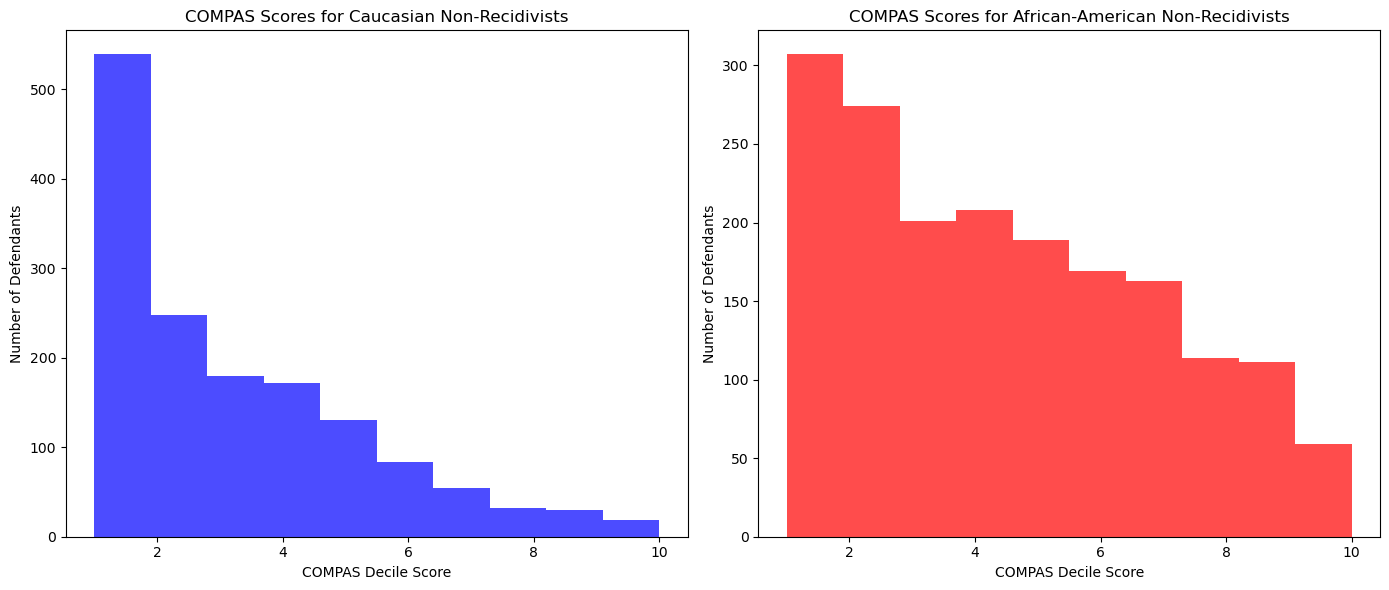

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'decile_score', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 过滤出未在两年内再犯的被告
non_recidivist_df = compas_df[compas_df['two_year_recid'] == 0]

# 定义高分的阈值
high_score_threshold = 7

# 计算白人高分比例
white_non_recidivists = non_recidivist_df[non_recidivist_df['race'] == 'Caucasian']
white_high_score_proportion = (white_non_recidivists['decile_score'] >= high_score_threshold).mean()

# 计算黑人高分比例
black_non_recidivists = non_recidivist_df[non_recidivist_df['race'] == 'African-American']
black_high_score_proportion = (black_non_recidivists['decile_score'] >= high_score_threshold).mean()

print(f"The percentage of whites who do not repeat high scores: {white_high_score_proportion * 100:.2f}%")
print(f"Percentage of blacks who do not repeat high scores: {black_high_score_proportion * 100:.2f}%")

# 设置图表大小
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# 白人未再犯分布
axes[0].hist(white_non_recidivists['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0].set_title('COMPAS Scores for Caucasian Non-Recidivists')
axes[0].set_xlabel('COMPAS Decile Score')
axes[0].set_ylabel('Number of Defendants')

# 黑人未再犯分布
axes[1].hist(black_non_recidivists['decile_score'], bins=10, alpha=0.7, color='red')
axes[1].set_title('COMPAS Scores for African-American Non-Recidivists')
axes[1].set_xlabel('COMPAS Decile Score')
axes[1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()



In [ ]:
其次研究再两年内再犯的数据集中，黑种人和白种人的分布情况，以及分数情况，我们可以观测出，白人获得高分的再次犯罪的比例只有29.3%，
但黑人获得高分的再次犯罪比例却有51.45%之多，相差1.75倍

Percentage of white recidivism: 29.30%
Percentage of black recidivism: 51.45%


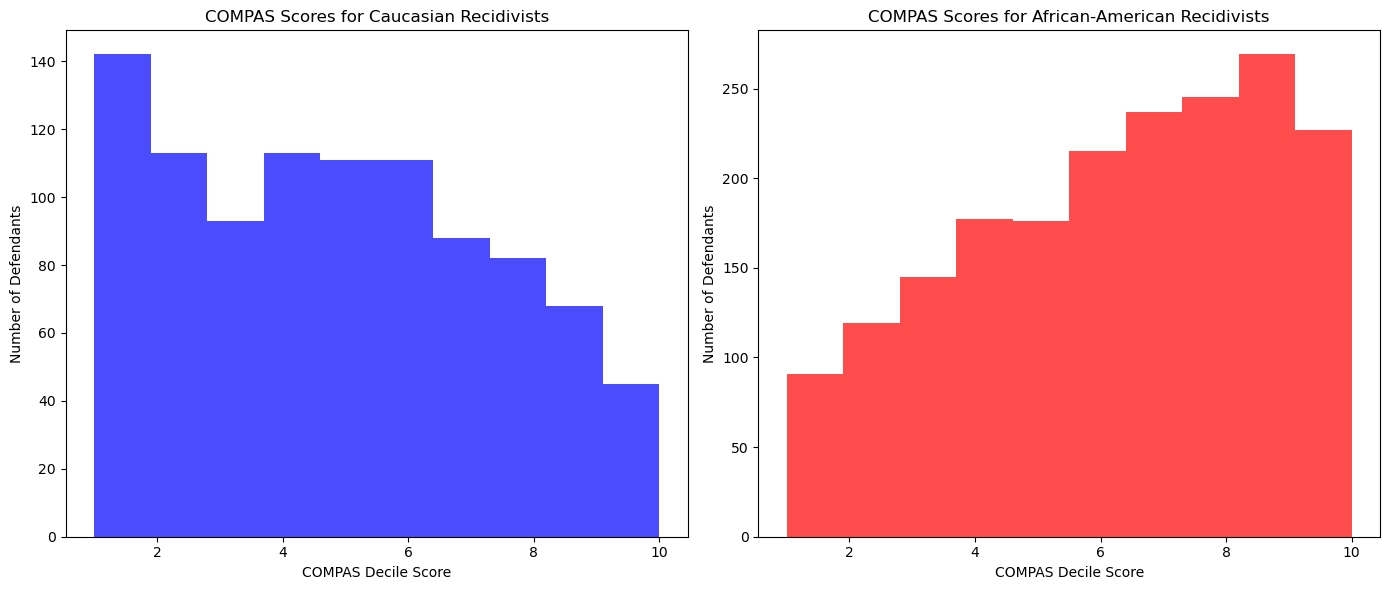

In [2]:
# 过滤掉在两年内再犯的被告
recidivist_df = compas_df[compas_df['two_year_recid'] == 1]

# 定义高分的阈值
high_score_threshold = 7

# 计算白人高分比例
white_recidivists = recidivist_df[recidivist_df['race'] == 'Caucasian']
white_high_score_proportion = (white_recidivists['decile_score'] >= high_score_threshold).mean()

# 计算黑人高分比例
black_recidivists = recidivist_df[recidivist_df['race'] == 'African-American']
black_high_score_proportion = (black_recidivists['decile_score'] >= high_score_threshold).mean()

print(f"Percentage of white recidivism: {white_high_score_proportion * 100:.2f}%")
print(f"Percentage of black recidivism: {black_high_score_proportion * 100:.2f}%")

# 设置图表大小
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# 白人再犯分布
axes[0].hist(white_recidivists['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0].set_title('COMPAS Scores for Caucasian Recidivists')
axes[0].set_xlabel('COMPAS Decile Score')
axes[0].set_ylabel('Number of Defendants')

# 黑人再犯分布
axes[1].hist(black_recidivists['decile_score'], bins=10, alpha=0.7, color='red')
axes[1].set_title('COMPAS Scores for African-American Recidivists')
axes[1].set_xlabel('COMPAS Decile Score')
axes[1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()


In [ ]:
人种bias⬆️
从以上图表中总结：在两年内并没有再次犯罪的成员中，黑种人的分布更平均，而白种人则集中在较低的分数区间内，但是通过两年内累犯的数据分布
情况可以看出，白种人低分犯罪率反而高，黑种人则是基本随着分数升高人数递增的，所以从中可以发现bias的所在之处

In [ ]:
打分的情况具有不公平性，首先考虑是不是因为训练集白人黑人比例不同的原因呢？导致黑人更容易被打成高分
所以我控制黑人数据集的数量随机成相等于白人数据集的数量
进行预测，预测后再次观察种族未再犯的高分比例是否 比白人未再犯高分比例: 9.14% 黑人未再犯高分比例: 24.90%，优化了

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'decile_score', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['race'] = compas_df['race'].map({'African-American': 1, 'Caucasian': 0, 'Hispanic': 2, 'Asian': 3, 'Native American': 4, 'Other': 5})
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})

# 过滤出白人和黑人
white_df = compas_df[compas_df['race'] == 0]
black_df = compas_df[compas_df['race'] == 1]

# 随机抽取等量的黑人数据
balanced_black_df = black_df.sample(n=len(white_df), random_state=42)

# 合并平衡后的数据集
balanced_df = pd.concat([white_df, balanced_black_df])

# 分割数据集为特征和目标变量
X = balanced_df.drop(columns=['two_year_recid', 'decile_score'])
y = balanced_df['two_year_recid']


In [5]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 初始化并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 计算准确性
accuracy = accuracy_score(y_test, y_pred)
print(f"预测的准确性: {accuracy * 100:.2f}%")

# 显示混淆矩阵和分类报告
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("混淆矩阵：")
print(conf_matrix)

print("分类报告：")
print(class_report)


预测的准确性: 66.06%
混淆矩阵：
[[616 185]
 [315 357]]
分类报告：
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       801
           1       0.66      0.53      0.59       672

    accuracy                           0.66      1473
   macro avg       0.66      0.65      0.65      1473
weighted avg       0.66      0.66      0.66      1473



In [ ]:
我也单独跑过全部的白种人黑种人数据集的准确率 大概是68%
所以说越大的样本容量准确率肯定是越高的
面临的问题就是 ：
控制黑白数量相等 会减少偏见 但准确率下降
保证样本容量优先 会有较多偏见 但准确率上升

值得思考🤔


White people who do not reoffend get high scores: 8.61%
Black people who do not reoffend get high scores: 19.78%


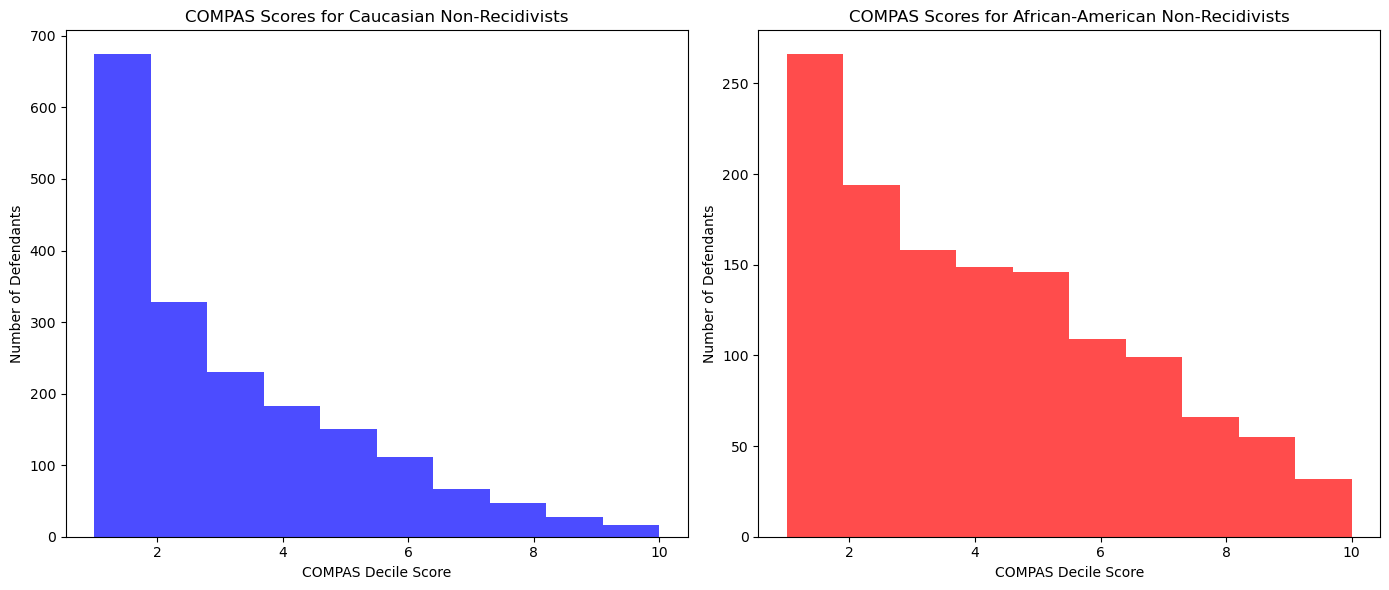

In [6]:
# 添加预测结果到数据集
balanced_df['predicted'] = model.predict(scaler.transform(X))

# 定义高分的阈值
high_score_threshold = 7

# 过滤出未再犯者
non_recidivist_df = balanced_df[balanced_df['predicted'] == 0]

# 计算白人未再犯高分比例
white_non_recidivists = non_recidivist_df[non_recidivist_df['race'] == 0]
white_high_score_proportion = (white_non_recidivists['decile_score'] >= high_score_threshold).mean()

# 计算黑人未再犯高分比例
black_non_recidivists = non_recidivist_df[non_recidivist_df['race'] == 1]
black_high_score_proportion = (black_non_recidivists['decile_score'] >= high_score_threshold).mean()

print(f"White people who do not reoffend get high scores: {white_high_score_proportion * 100:.2f}%")
print(f"Black people who do not reoffend get high scores: {black_high_score_proportion * 100:.2f}%")

# 设置图表大小
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# 白人未再犯分布
axes[0].hist(white_non_recidivists['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0].set_title('COMPAS Scores for Caucasian Non-Recidivists')
axes[0].set_xlabel('COMPAS Decile Score')
axes[0].set_ylabel('Number of Defendants')

# 黑人未再犯分布
axes[1].hist(black_non_recidivists['decile_score'], bins=10, alpha=0.7, color='red')
axes[1].set_title('COMPAS Scores for African-American Non-Recidivists')
axes[1].set_xlabel('COMPAS Decile Score')
axes[1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()


In [ ]:
之前白人与黑人获得高分但未犯罪的比例是 9.14% 和 24.9%，现在是 8.61% 和 19.78% 与自己横向比较，高分但未犯罪的比率均下降了
纵向比较，现在黑白人种的高分未犯罪比率相差了 11.17%，相比于之前的15.76%，性能提高了1.41倍，
由此我们可以得出，一个合适的样本均衡的数据集，对模型的公平性上有很大作用
举一反三 仅仅是控制了种族的相同 就可以提升1.41倍
那如果我将性别 年龄分布全部变成均衡，那训练出来的模型可以提高自己预测的准确性

In [ ]:
接下来研究年龄的分布：

Accuracy of prediction: 68.36%
Confusion Matrix：
[[942 265]
 [420 538]]
Classified report：
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1207
           1       0.67      0.56      0.61       958

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165

高分比例：{'再犯_25岁以下': 0.5263774912075029, '再犯_25岁以上': 0.5323863636363636, '未再犯_25岁以下': 0.26479289940828404, '未再犯_25岁以上': 0.10955414012738854}


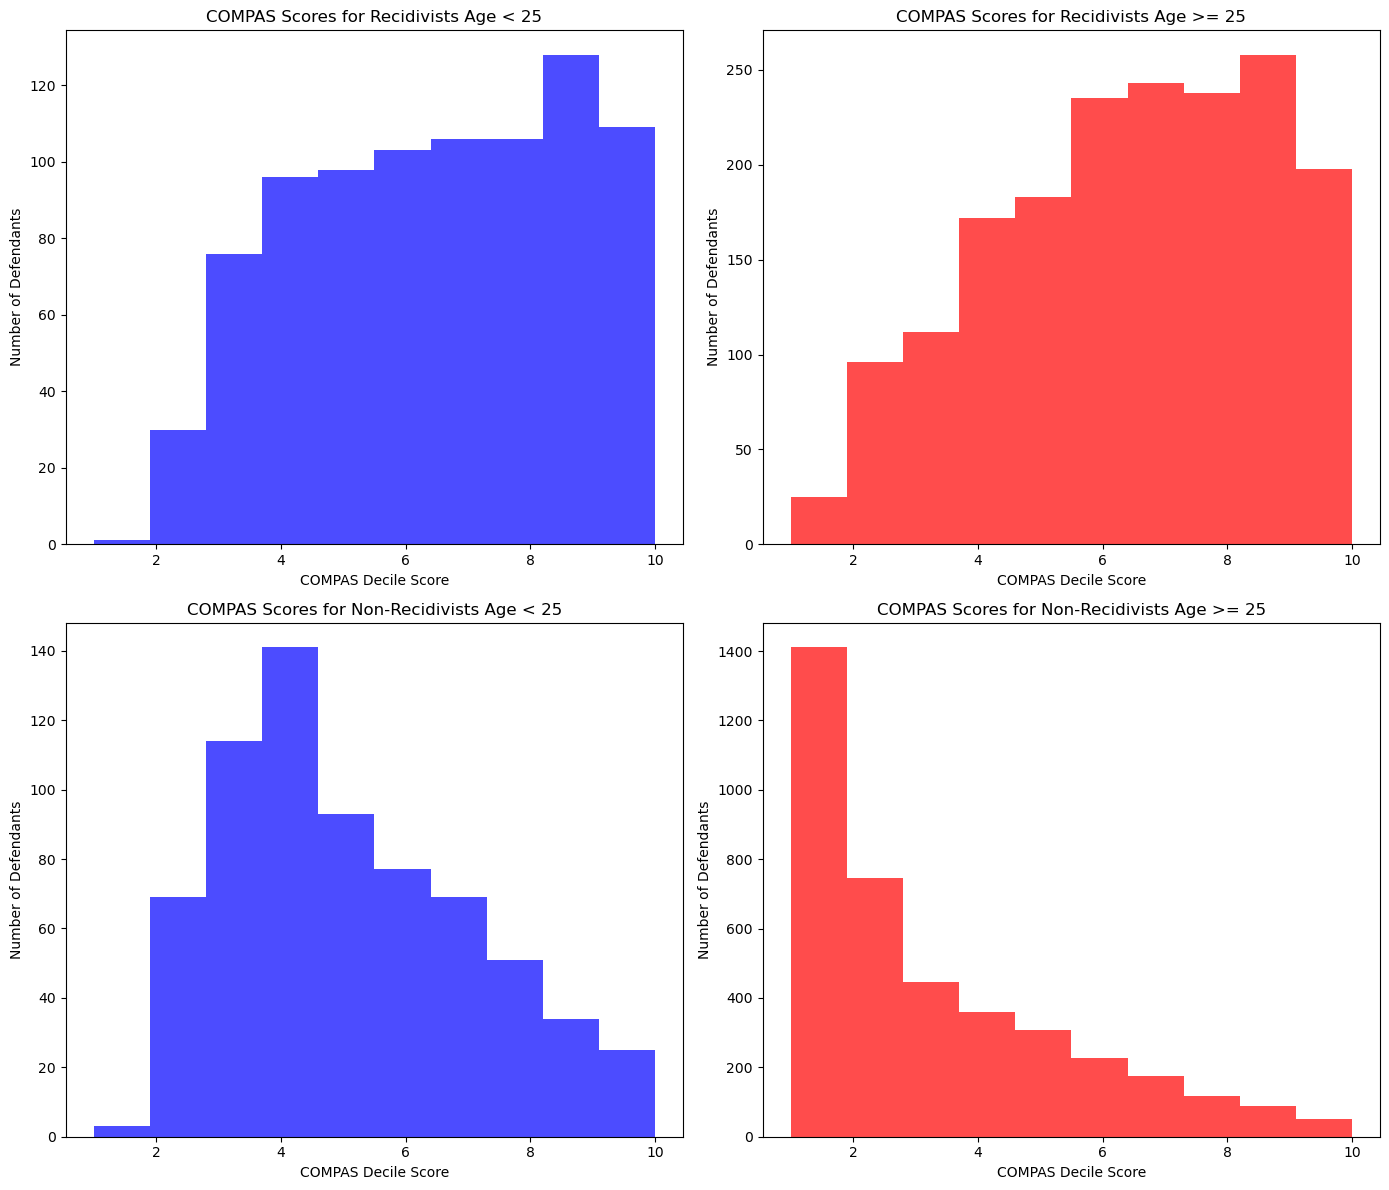

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'decile_score', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['race'] = compas_df['race'].map({'African-American': 1, 'Caucasian': 0, 'Hispanic': 2, 'Asian': 3, 'Native American': 4, 'Other': 5})
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})

# 分割数据集为特征和目标变量
X = compas_df.drop(columns=['two_year_recid', 'decile_score'])
y = compas_df['two_year_recid']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 初始化并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 计算准确性
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of prediction: {accuracy * 100:.2f}%")

# 显示混淆矩阵和分类报告
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix：")
print(conf_matrix)

print("Classified report：")
print(class_report)


# 添加预测结果到数据集
compas_df['predicted'] = model.predict(scaler.transform(X))

# 定义高分的阈值
high_score_threshold = 7

# 过滤出再犯和非再犯的被告
recidivist_df = compas_df[compas_df['predicted'] == 1]
non_recidivist_df = compas_df[compas_df['predicted'] == 0]

# 过滤出25岁以上和25岁以下的被告
age_below_25 = compas_df[compas_df['age'] < 25]
age_above_25 = compas_df[compas_df['age'] >= 25]

# 计算25岁以下和以上被告的高分比例
def calculate_high_score_proportion(df):
    return (df['decile_score'] >= high_score_threshold).mean()

# 计算再犯和非再犯的高分比例
proportions = {
    "再犯_25岁以下": calculate_high_score_proportion(recidivist_df[recidivist_df['age'] < 25]),
    "再犯_25岁以上": calculate_high_score_proportion(recidivist_df[recidivist_df['age'] >= 25]),
    "未再犯_25岁以下": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['age'] < 25]),
    "未再犯_25岁以上": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['age'] >= 25])
}

print(f"高分比例：{proportions}")

# 绘制分布图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# 再犯 25岁以下
axes[0, 0].hist(recidivist_df[recidivist_df['age'] < 25]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0, 0].set_title('COMPAS Scores for Recidivists Age < 25')
axes[0, 0].set_xlabel('COMPAS Decile Score')
axes[0, 0].set_ylabel('Number of Defendants')

# 再犯 25岁以上
axes[0, 1].hist(recidivist_df[recidivist_df['age'] >= 25]['decile_score'], bins=10, alpha=0.7, color='red')
axes[0, 1].set_title('COMPAS Scores for Recidivists Age >= 25')
axes[0, 1].set_xlabel('COMPAS Decile Score')
axes[0, 1].set_ylabel('Number of Defendants')

# 未再犯 25岁以下
axes[1, 0].hist(non_recidivist_df[non_recidivist_df['age'] < 25]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[1, 0].set_title('COMPAS Scores for Non-Recidivists Age < 25')
axes[1, 0].set_xlabel('COMPAS Decile Score')
axes[1, 0].set_ylabel('Number of Defendants')

# 未再犯 25岁以上
axes[1, 1].hist(non_recidivist_df[non_recidivist_df['age'] >= 25]['decile_score'], bins=10, alpha=0.7, color='red')
axes[1, 1].set_title('COMPAS Scores for Non-Recidivists Age >= 25')
axes[1, 1].set_xlabel('COMPAS Decile Score')
axes[1, 1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()

In [ ]:
我们可以看出 在实际情况中 再犯的25岁以上以下的比率基本相同：0.532和0.526，但在未犯的评分中（0.265和0.110）高分比例会相差2.4倍之多
所以在年龄方面 存在bias
同样的方法，控制两个年龄段样本数量一样

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'decile_score', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['race'] = compas_df['race'].map({'African-American': 1, 'Caucasian': 0, 'Hispanic': 2, 'Asian': 3, 'Native American': 4, 'Other': 5})
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})

# 过滤出25岁以上和以下的数据
age_below_25 = compas_df[compas_df['age'] < 25]
age_above_25 = compas_df[compas_df['age'] >= 25]

# 随机抽取等量的数据
sample_size = min(len(age_below_25), len(age_above_25))
age_below_25 = age_below_25.sample(n=sample_size, random_state=42)
age_above_25 = age_above_25.sample(n=sample_size, random_state=42)

# 合并平衡后的数据集
balanced_df = pd.concat([age_below_25, age_above_25])

# 分割数据集为特征和目标变量
X = balanced_df.drop(columns=['two_year_recid', 'decile_score'])
y = balanced_df['two_year_recid']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 初始化并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 计算准确性
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of prediction: {accuracy * 100:.2f}%")

# 显示混淆矩阵和分类报告
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix：")
print(conf_matrix)

print("Classified report：")
print(class_report)


Accuracy of prediction: 69.93%
Confusion Matrix：
[[312 137]
 [139 330]]
Classified report：
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       449
           1       0.71      0.70      0.71       469

    accuracy                           0.70       918
   macro avg       0.70      0.70      0.70       918
weighted avg       0.70      0.70      0.70       918



高分比例：{'再犯_25岁以下': 0.4899598393574297, '再犯_25岁以上': 0.5293040293040293, '未再犯_25岁以下': 0.2626641651031895, '未再犯_25岁以上': 0.10579857578840285}


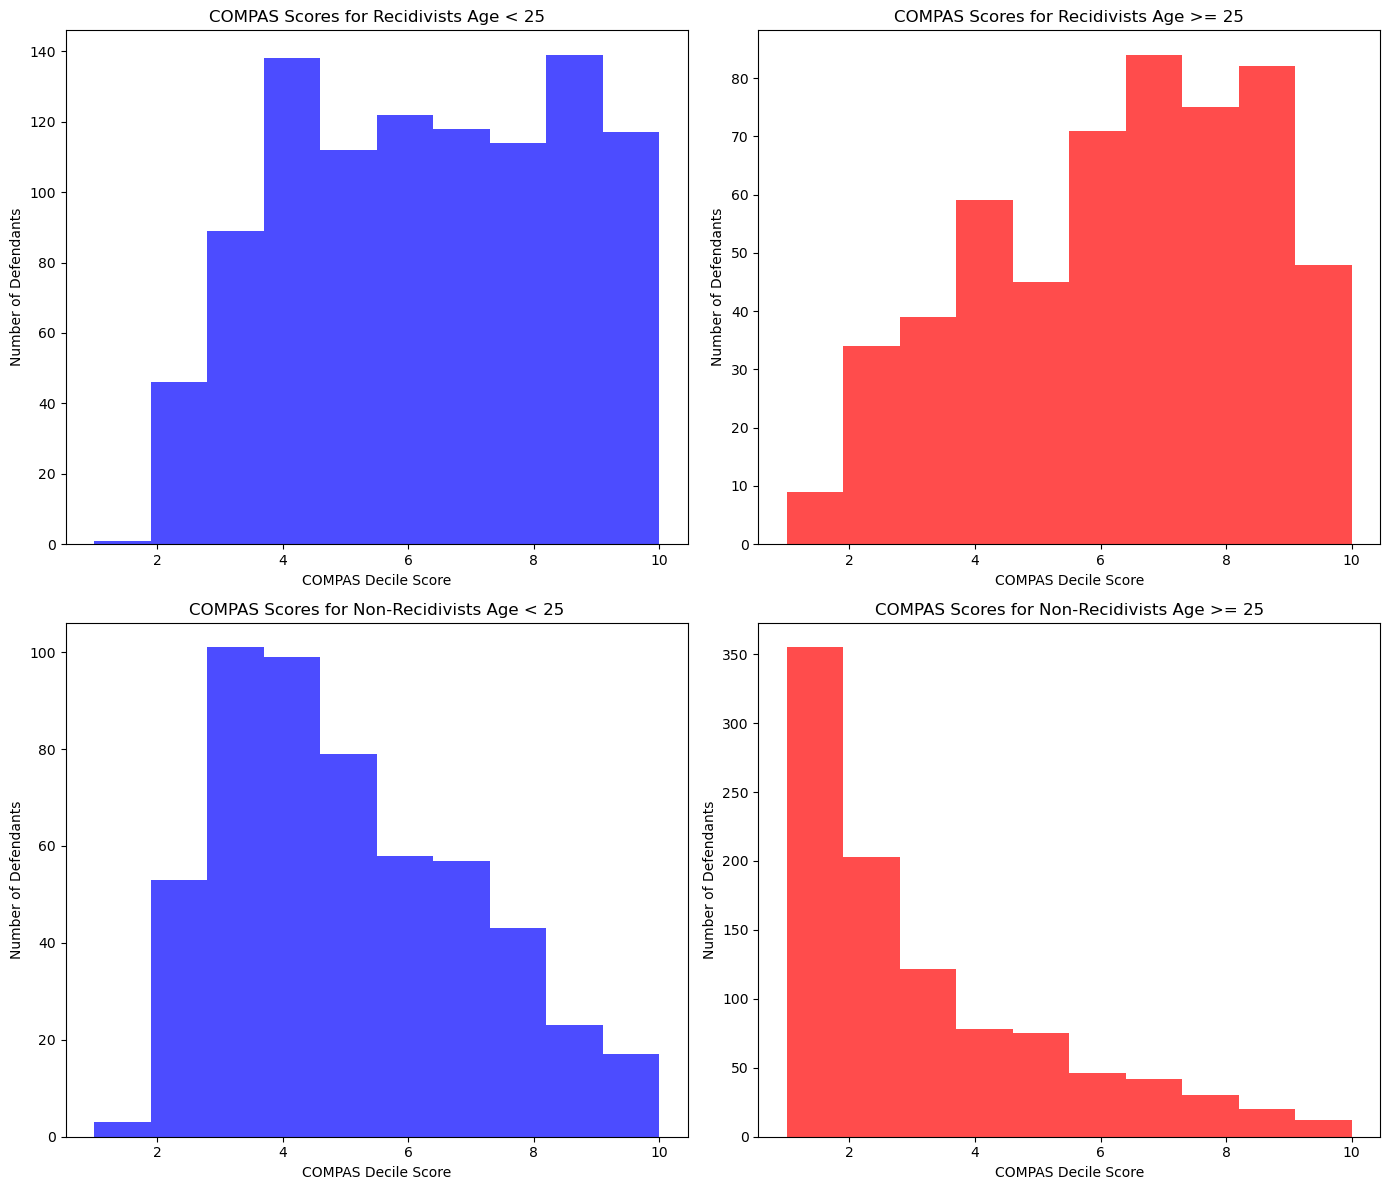

In [43]:
# 添加预测结果到数据集
balanced_df['predicted'] = model.predict(scaler.transform(X))

# 定义高分的阈值
high_score_threshold = 7

# 过滤出再犯和非再犯的被告
recidivist_df = balanced_df[balanced_df['predicted'] == 1]
non_recidivist_df = balanced_df[balanced_df['predicted'] == 0]

# 计算高分比例函数
def calculate_high_score_proportion(df):
    return (df['decile_score'] >= high_score_threshold).mean()

# 计算再犯和非再犯的高分比例
proportions = {
    "再犯_25岁以下": calculate_high_score_proportion(recidivist_df[recidivist_df['age'] < 25]),
    "再犯_25岁以上": calculate_high_score_proportion(recidivist_df[recidivist_df['age'] >= 25]),
    "未再犯_25岁以下": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['age'] < 25]),
    "未再犯_25岁以上": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['age'] >= 25])
}

print(f"高分比例：{proportions}")

# 绘制分布图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# 再犯 25岁以下
axes[0, 0].hist(recidivist_df[recidivist_df['age'] < 25]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0, 0].set_title('COMPAS Scores for Recidivists Age < 25')
axes[0, 0].set_xlabel('COMPAS Decile Score')
axes[0, 0].set_ylabel('Number of Defendants')

# 再犯 25岁以上
axes[0, 1].hist(recidivist_df[recidivist_df['age'] >= 25]['decile_score'], bins=10, alpha=0.7, color='red')
axes[0, 1].set_title('COMPAS Scores for Recidivists Age >= 25')
axes[0, 1].set_xlabel('COMPAS Decile Score')
axes[0, 1].set_ylabel('Number of Defendants')

# 未再犯 25岁以下
axes[1, 0].hist(non_recidivist_df[non_recidivist_df['age'] < 25]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[1, 0].set_title('COMPAS Scores for Non-Recidivists Age < 25')
axes[1, 0].set_xlabel('COMPAS Decile Score')
axes[1, 0].set_ylabel('Number of Defendants')

# 未再犯 25岁以上
axes[1, 1].hist(non_recidivist_df[non_recidivist_df['age'] >= 25]['decile_score'], bins=10, alpha=0.7, color='red')
axes[1, 1].set_title('COMPAS Scores for Non-Recidivists Age >= 25')
axes[1, 1].set_xlabel('COMPAS Decile Score')
axes[1, 1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()

In [ ]:
准确率提升了 
但其实我有点不解：
因为25岁以下高分的再犯比率下降了 
但为什么在未犯但高分的比例没有大的变动呢？
是因为 在年龄这个变量上 控制样本数量不起明显作用么

In [ ]:
性别方面：

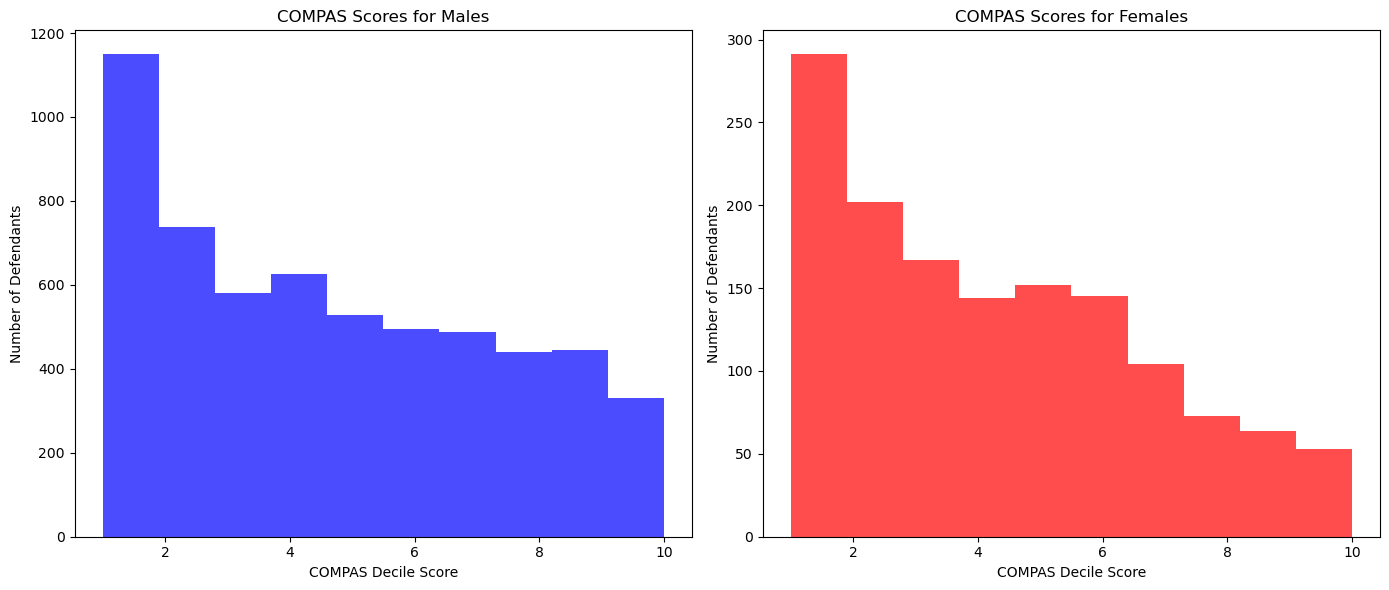

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['sex', 'decile_score']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将性别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})

# 设置图表大小
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# 男性得分分布
male_scores = compas_df[compas_df['sex'] == 1]['decile_score']
axes[0].hist(male_scores, bins=10, alpha=0.7, color='blue')
axes[0].set_title('COMPAS Scores for Males')
axes[0].set_xlabel('COMPAS Decile Score')
axes[0].set_ylabel('Number of Defendants')

# 女性得分分布
female_scores = compas_df[compas_df['sex'] == 0]['decile_score']
axes[1].hist(female_scores, bins=10, alpha=0.7, color='red')
axes[1].set_title('COMPAS Scores for Females')
axes[1].set_xlabel('COMPAS Decile Score')
axes[1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()


In [ ]:
图片看着分布基本相同

高分比例：{'再犯_男性': 0.42717035960770067, '再犯_女性': 0.3514056224899598, '未再犯_男性': 0.17123287671232876, '未再犯_女性': 0.1326644370122631}


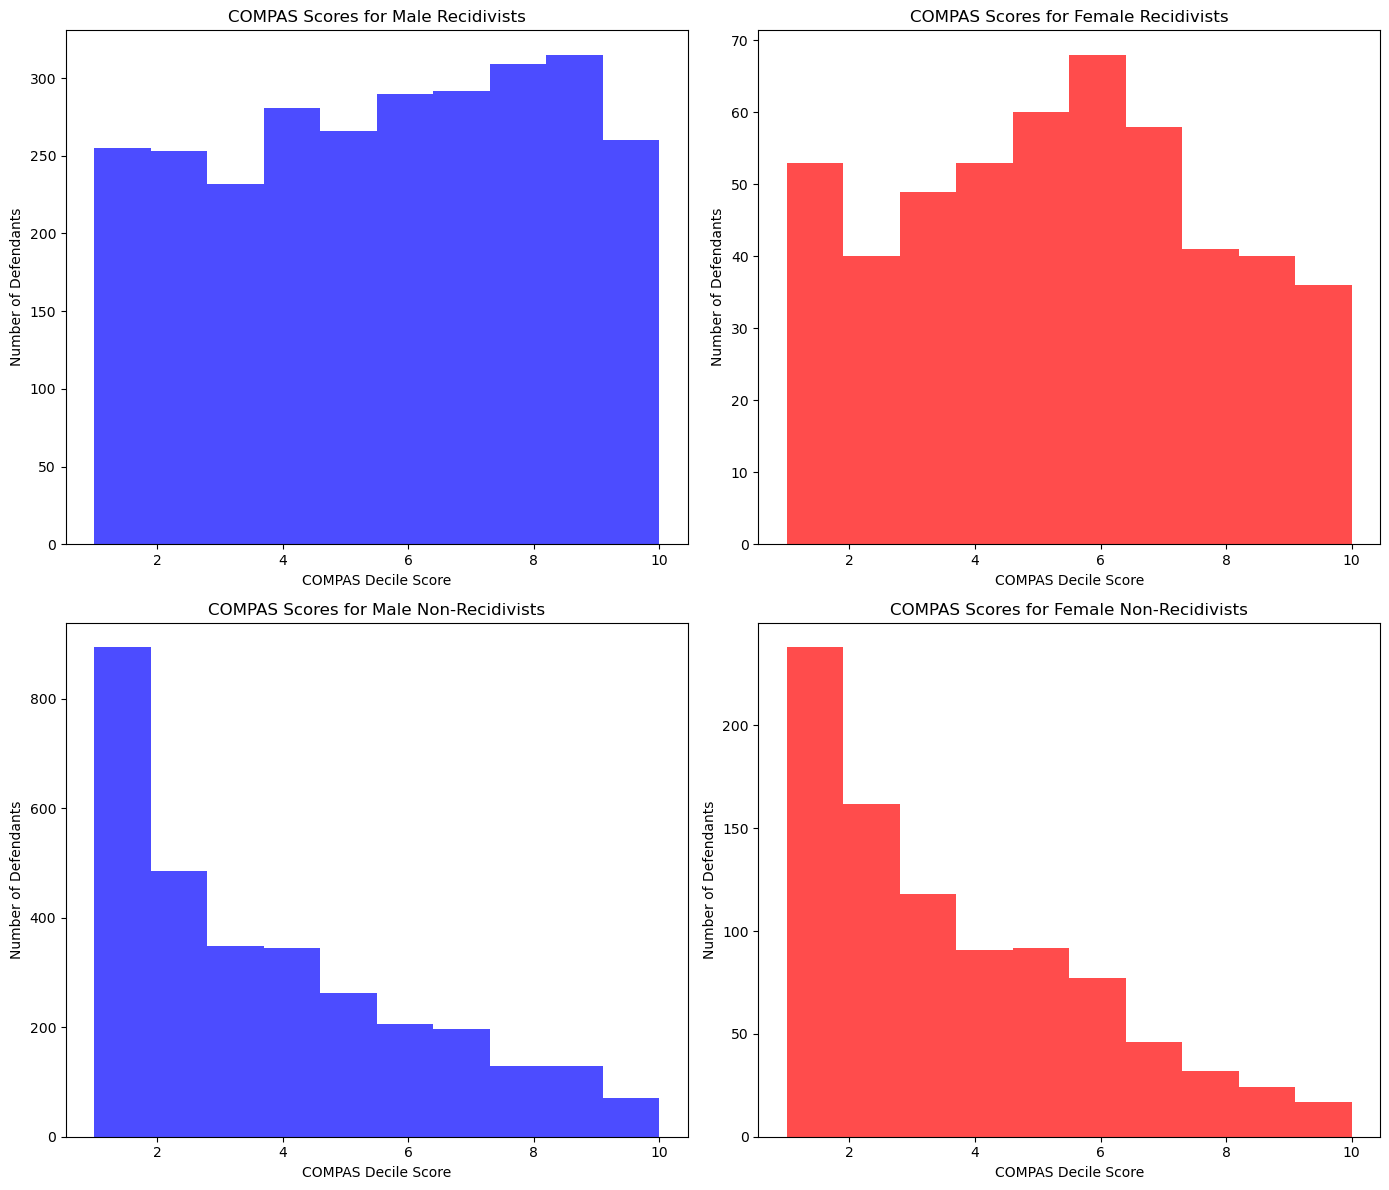

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['sex', 'decile_score', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将性别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})

# 定义高分的阈值
high_score_threshold = 7

# 过滤出再犯和未再犯的被告
recidivist_df = compas_df[compas_df['two_year_recid'] == 1]
non_recidivist_df = compas_df[compas_df['two_year_recid'] == 0]

# 计算高分比例函数
def calculate_high_score_proportion(df):
    return (df['decile_score'] >= high_score_threshold).mean()

# 计算再犯和未再犯的高分比例
proportions = {
    "再犯_男性": calculate_high_score_proportion(recidivist_df[recidivist_df['sex'] == 1]),
    "再犯_女性": calculate_high_score_proportion(recidivist_df[recidivist_df['sex'] == 0]),
    "未再犯_男性": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['sex'] == 1]),
    "未再犯_女性": calculate_high_score_proportion(non_recidivist_df[non_recidivist_df['sex'] == 0])
}

print(f"高分比例：{proportions}")

# 设置图表大小
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# 再犯男性分布
axes[0, 0].hist(recidivist_df[recidivist_df['sex'] == 1]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[0, 0].set_title('COMPAS Scores for Male Recidivists')
axes[0, 0].set_xlabel('COMPAS Decile Score')
axes[0, 0].set_ylabel('Number of Defendants')

# 再犯女性分布
axes[0, 1].hist(recidivist_df[recidivist_df['sex'] == 0]['decile_score'], bins=10, alpha=0.7, color='red')
axes[0, 1].set_title('COMPAS Scores for Female Recidivists')
axes[0, 1].set_xlabel('COMPAS Decile Score')
axes[0, 1].set_ylabel('Number of Defendants')

# 未再犯男性分布
axes[1, 0].hist(non_recidivist_df[non_recidivist_df['sex'] == 1]['decile_score'], bins=10, alpha=0.7, color='blue')
axes[1, 0].set_title('COMPAS Scores for Male Non-Recidivists')
axes[1, 0].set_xlabel('COMPAS Decile Score')
axes[1, 0].set_ylabel('Number of Defendants')

# 未再犯女性分布
axes[1, 1].hist(non_recidivist_df[non_recidivist_df['sex'] == 0]['decile_score'], bins=10, alpha=0.7, color='red')
axes[1, 1].set_title('COMPAS Scores for Female Non-Recidivists')
axes[1, 1].set_xlabel('COMPAS Decile Score')
axes[1, 1].set_ylabel('Number of Defendants')

# 调整布局
plt.tight_layout()
plt.show()



In [ ]:
我阅读文献：令人惊讶的是，尽管女性犯罪率总体较低，但在控制相同因素的情况下，女性被告获得更高评分的可能性比男性高出 19.4％。
所以我尝试一下如果控制种族 年龄阶段相同 是否能得出这个bias的结论：


In [70]:
import pandas as pd

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'decile_score']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['race'] = compas_df['race'].map({'African-American': 1, 'Caucasian': 0, 'Hispanic': 2, 'Asian': 3, 'Native American': 4, 'Other': 5})
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})


In [71]:
import statsmodels.api as sm

# 定义高分的阈值
high_score_threshold = 7
compas_df['high_score'] = compas_df['decile_score'] >= high_score_threshold

# 定义自变量和因变量
X = compas_df[['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree']]
y = compas_df['high_score']

# 添加常数项
X = sm.add_constant(X)

# 拟合逻辑回归模型
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 打印结果
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.449497
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             high_score   No. Observations:                 7214
Model:                          Logit   Df Residuals:                     7206
Method:                           MLE   Df Model:                            7
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                  0.2377
Time:                        00:01:31   Log-Likelihood:                -3242.7
converged:                       True   LL-Null:                       -4253.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7881      0.144      5.458      0.000       0.505       1.071
age           

In [ ]:
常数项（const）: 0.7881，表示在所有自变量为0时的基线得分。
年龄（age）: -0.0898，表示年龄每增加一岁，获得高分的概率降低。
性别（sex）: 0.0950，尽管系数为正，但p值为0.242，表示性别对高分的影响在统计上不显著。
种族（race）: -0.0894，种族对高分有显著负面影响。
未成年重罪次数（juv_fel_count）: 0.6578，显著正相关。
未成年轻罪次数（juv_misd_count）: 0.4937，显著正相关。
之前的犯罪次数（priors_count）: 0.2244，显著正相关。
当前指控级别（c_charge_degree）: 0.3045，显著正相关。

In [ ]:
结论：没研究出来 不知道那句话怎么来的

In [2]:
pip install shap lime


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost 

Note: you may need to restart the kernel to use updated packages.


/Users/huashenglong/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


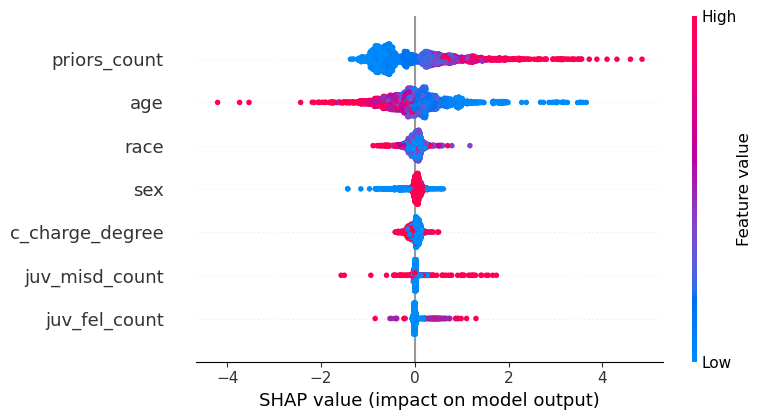

In [4]:
import shap
import xgboost
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree']
compas_df = compas_df[features + ['two_year_recid']].dropna()

# 将类别特征编码为类别类型
compas_df['sex'] = compas_df['sex'].astype('category').cat.codes
compas_df['race'] = compas_df['race'].astype('category').cat.codes
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].astype('category').cat.codes

# 分割数据集为特征和目标变量
X = compas_df[features]
y = compas_df['two_year_recid']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练模型
model = xgboost.XGBClassifier(use_label_encoder=False, enable_categorical=True).fit(X_train, y_train)

# 创建 SHAP 解释器
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 绘制 SHAP 值
shap.summary_plot(shap_values, X_test)


In [ ]:
priors_count（之前的犯罪次数）：影响最大，正值表示增加再犯概率。
age（年龄）：负值较多，表示年龄较大减少再犯概率。
race（种族）：影响较小，负值较多，可能表示特定种族减少再犯概率。
sex（性别）：正值较多，表示性别为男性增加再犯概率。
c_charge_degree（当前指控级别）：正值较多，表示更严重的指控增加再犯概率。
juv_misd_count（未成年轻罪次数）和juv_fel_count（未成年重罪次数）：正值较多，表示更多的未成年犯罪记录增加再犯概率。

In [39]:
import lime
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 加载并处理数据
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择相关特征并保留 'two_year_recid' 作为目标变量
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值，保留所有类别列
compas_df = pd.get_dummies(compas_df, columns=['sex', 'race', 'c_charge_degree'], drop_first=False)

# 分割数据集为特征和目标变量
X = compas_df.drop(columns=['two_year_recid'])
y = compas_df['two_year_recid']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 计算模型准确率
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# 创建 LIME 解释器
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['Not Recidivated', 'Recidivated'], mode='classification')

# 选择要解释的实例
i = 25
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=5)

# 显示解释结果
exp.show_in_notebook(show_table=True)


Model accuracy: 0.68


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'two_year_recid']
compas_df = compas_df[features].dropna()

# 将类别特征编码为数值类型
compas_df['sex'] = compas_df['sex'].astype('category').cat.codes
compas_df['race'] = compas_df['race'].astype('category').cat.codes
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].astype('category').cat.codes

# 分割数据集为特征和目标变量
X = compas_df.drop(columns=['two_year_recid'])
y = compas_df['two_year_recid']

def proxi_mix(X, y, k=5, d=0.5):
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)
    
    new_X = []
    new_y = []
    
    for i in range(len(X)):
        for j in range(1, k+1):
            lam = np.random.beta(d, d)
            new_sample = lam * X[i] + (1 - lam) * X[indices[i][j]]
            new_label = int(round(lam * y[i] + (1 - lam) * y[indices[i][j]]))
            new_X.append(new_sample)
            new_y.append(new_label)
    
    return np.array(new_X), np.array(new_y)

# 使用 ProxiMix 增强数据集
X_new, y_new = proxi_mix(X.values, y.values)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 分割增强后的数据集
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# 训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 输出分类报告
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.78      0.72      5880
           1       0.67      0.53      0.59      4941

    accuracy                           0.67     10821
   macro avg       0.67      0.66      0.66     10821
weighted avg       0.67      0.67      0.66     10821



In [15]:
def demographic_parity(y_true, y_pred, group):
    group_0 = group == 0
    group_1 = group == 1
    positive_rate_0 = np.mean(y_pred[group_0])
    positive_rate_1 = np.mean(y_pred[group_1])
    return positive_rate_1 - positive_rate_0

# 原始数据集上的 Demographic Parity
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
model_orig = LogisticRegression(max_iter=1000)
model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = model_orig.predict(X_test_orig)
dp_orig = demographic_parity(y_test_orig, y_pred_orig, X_test_orig['sex'])

# 增强数据集上的 Demographic Parity
dp_proxi = demographic_parity(y_test, y_pred, X_test[:, 1])  # 1表示sex列的索引

print(f"原始数据集的 Demographic Parity: {dp_orig}")
print(f"增强数据集的 Demographic Parity: {dp_proxi}")


原始数据集的 Demographic Parity: 0.29831627477575023
增强数据集的 Demographic Parity: 0.3842312605330671


In [16]:
from sklearn.metrics import confusion_matrix

def equalized_odds(y_true, y_pred, group):
    cm_group1 = confusion_matrix(y_true[group == 1], y_pred[group == 1]).ravel()
    cm_group0 = confusion_matrix(y_true[group == 0], y_pred[group == 0]).ravel()
    
    tpr_group1 = cm_group1[3] / (cm_group1[3] + cm_group1[1]) if (cm_group1[3] + cm_group1[1]) > 0 else 0
    tpr_group0 = cm_group0[3] / (cm_group0[3] + cm_group0[1]) if (cm_group0[3] + cm_group0[1]) > 0 else 0
    
    fpr_group1 = cm_group1[2] / (cm_group1[2] + cm_group1[0]) if (cm_group1[2] + cm_group1[0]) > 0 else 0
    fpr_group0 = cm_group0[2] / (cm_group0[2] + cm_group0[0]) if (cm_group0[2] + cm_group0[0]) > 0 else 0
    
    tpr_diff = abs(tpr_group1 - tpr_group0)
    fpr_diff = abs(fpr_group1 - fpr_group0)
    
    return tpr_diff, fpr_diff

# 计算原始数据集上的 Equalized Odds
eodds_orig = equalized_odds(y_test_orig, y_pred_orig, X_test_orig['sex'])

# 计算增强数据集上的 Equalized Odds
eodds_proxi = equalized_odds(y_test, y_pred, X_test[:, 1])  # 1表示sex列的索引

print(f"原始数据集的 Equalized Odds: TPR差异={eodds_orig[0]}, FPR差异={eodds_orig[1]}")
print(f"增强数据集的 Equalized Odds: TPR差异={eodds_proxi[0]}, FPR差异={eodds_proxi[1]}")


原始数据集的 Equalized Odds: TPR差异=0.022043174217087236, FPR差异=0.006702000833081978
增强数据集的 Equalized Odds: TPR差异=0.034413347685683604, FPR差异=0.046892327113240206


In [ ]:
用了Proximix反而让模型的预测性能和公平性双双下降
主要原因是：逻辑回归可能不足以捕捉增强数据集中的复杂模式。
在此基础上：
1. 使用更复杂的模型
我们可以尝试使用更复杂的模型，例如随机森林或梯度提升树。

2. 结合其他公平性技术
我们可以结合其他公平性增强技术，如重新加权、对抗性训练或公平性正则化，进一步减少模型偏差。

In [4]:
pip install fairlearn


  Using cached numpy-2.1.0-cp311-cp311-macosx_12_0_arm64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 2.1.0 which is incompatible.
tensorflow 2.16.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择感兴趣的特征
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'two_year_recid']
compas_df = compas_df[features].dropna()

# 将类别特征编码为数值类型
compas_df['sex'] = compas_df['sex'].astype('category').cat.codes
compas_df['race'] = compas_df['race'].astype('category').cat.codes
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].astype('category').cat.codes

# 分割数据集为特征和目标变量
X = compas_df.drop(columns=['two_year_recid'])
y = compas_df['two_year_recid']

def proxi_mix(X, y, k=10, d=1.0):
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)
    
    new_X = []
    new_y = []
    
    for i in range(len(X)):
        for j in range(1, k+1):
            lam = np.random.beta(d, d)
            new_sample = lam * X[i] + (1 - lam) * X[indices[i][j]]
            new_label = int(round(lam * y[i] + (1 - lam) * y[indices[i][j]]))
            new_X.append(new_sample)
            new_y.append(new_label)
    
    return np.array(new_X), np.array(new_y)

# 调整后的 ProxiMix
X_new, y_new = proxi_mix(X.values, y.values, k=10, d=1.0)

# 分割增强后的数据集
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# 使用增强数据集训练随机森林模型
model_proxi_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_proxi_rf.fit(X_train, y_train)

# 预测
y_pred_proxi_rf = model_proxi_rf.predict(X_test)

# 输出分类报告
print(classification_report(y_test, y_pred_proxi_rf))


              precision    recall  f1-score   support

           0       0.76      0.80      0.78     11824
           1       0.74      0.70      0.72      9818

    accuracy                           0.75     21642
   macro avg       0.75      0.75      0.75     21642
weighted avg       0.75      0.75      0.75     21642



In [28]:
# 分割原始数据集为训练集和测试集
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用原始数据集训练随机森林模型
model_orig_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_orig_rf.fit(X_train_orig, y_train_orig)

# 预测
y_pred_orig_rf = model_orig_rf.predict(X_test_orig)

# 输出分类报告
print("Classification report of the original datasets:")
print(classification_report(y_test_orig, y_pred_orig_rf))


# 调整后的 ProxiMix 增强数据集已经在之前步骤中生成
# X_new, y_new = proxi_mix(X.values, y.values, k=10, d=1.0)
# X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# 使用增强数据集训练随机森林模型
model_proxi_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_proxi_rf.fit(X_train, y_train)

# 预测
y_pred_proxi_rf = model_proxi_rf.predict(X_test)

# 输出分类报告
print("Enhanced classification reporting of datasets:")
print(classification_report(y_test, y_pred_proxi_rf))


Classification report of the original datasets:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1207
           1       0.58      0.58      0.58       958

    accuracy                           0.63      2165
   macro avg       0.62      0.62      0.62      2165
weighted avg       0.63      0.63      0.63      2165

Enhanced classification reporting of datasets:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     11824
           1       0.74      0.70      0.72      9818

    accuracy                           0.75     21642
   macro avg       0.75      0.75      0.75     21642
weighted avg       0.75      0.75      0.75     21642



In [30]:
def demographic_parity(y_true, y_pred, group):
    group_0 = group == 0
    group_1 = group == 1
    positive_rate_0 = np.mean(y_pred[group_0])
    positive_rate_1 = np.mean(y_pred[group_1])
    return positive_rate_1 - positive_rate_0

dp_orig_rf = demographic_parity(y_test_orig, y_pred_orig_rf, X_test_orig['sex'].values)

print(f"Original Demographic Parity: {dp_orig_rf}")

def equalized_odds(y_true, y_pred, group):
    cm_group1 = confusion_matrix(y_true[group == 1], y_pred[group == 1]).ravel()
    cm_group0 = confusion_matrix(y_true[group == 0], y_pred[group == 0]).ravel()
    
    tpr_group1 = cm_group1[3] / (cm_group1[3] + cm_group1[1]) if (cm_group1[3] + cm_group1[1]) > 0 else 0
    tpr_group0 = cm_group0[3] / (cm_group0[3] + cm_group0[1]) if (cm_group0[3] + cm_group0[1]) > 0 else 0
    
    fpr_group1 = cm_group1[2] / (cm_group1[2] + cm_group1[0]) if (cm_group1[2] + cm_group1[0]) > 0 else 0
    fpr_group0 = cm_group0[2] / (cm_group0[2] + cm_group0[0]) if (cm_group0[2] + cm_group0[0]) > 0 else 0
    
    tpr_diff = abs(tpr_group1 - tpr_group0)
    fpr_diff = abs(fpr_group1 - fpr_group0)
    
    return tpr_diff, fpr_diff

eodds_orig_rf = equalized_odds(y_test_orig, y_pred_orig_rf, X_test_orig['sex'].values)

print(f"Original Equalized Odds: TPR Difference={eodds_orig_rf[0]}, FPR Difference={eodds_orig_rf[1]}")

dp_proxi_rf = demographic_parity(y_test, y_pred_proxi_rf, X_test[:, 1])

print(f"Enhanced Demographic Parity: {dp_proxi_rf}")

eodds_proxi_rf = equalized_odds(y_test, y_pred_proxi_rf, X_test[:, 1])

print(f"Enhanced Equalized Odds: TPR Difference={eodds_proxi_rf[0]}, FPR Difference={eodds_proxi_rf[1]}")


Original Demographic Parity: 0.1571144443051392
Original Equalized Odds: TPR Difference=0.10083560046638163, FPR Difference=0.07235799026843803
Enhanced Demographic Parity: 0.1976787776565359
Enhanced Equalized Odds: TPR Difference=0.04313059739891545, FPR Difference=0.052685292713068155


In [ ]:
下面是针对引入公平约束前后的模型性能改变

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# 加载数据集
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# 选择相关特征并保留 'two_year_recid' 作为目标变量
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'two_year_recid']
compas_df = compas_df[features]

# 删除缺失值
compas_df = compas_df.dropna()

# 将类别特征编码为数值，保留所有类别列
compas_df = pd.get_dummies(compas_df, columns=['sex', 'race', 'c_charge_degree'], drop_first=False)

# 将数据集拆分为特征和目标变量
X = compas_df.drop(columns=['two_year_recid'])
y = compas_df['two_year_recid']

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 打印训练集列名，以确认敏感特征列名
print("训练集列名：", X_train.columns)

# 假设你找到了 'race_African-American' 列
sensitive_feature_col = 'race_African-American'  # 这里使用打印后确认的列名

# 定义逻辑回归模型
lr_model = LogisticRegression(max_iter=1000)

# --- 模型1：未引入公平性约束 ---
lr_model.fit(X_train, y_train)
y_pred_no_constraint = lr_model.predict(X_test)

# 计算未引入公平性约束时的准确率
accuracy_no_constraint = accuracy_score(y_test, y_pred_no_constraint)
print(f"未引入公平性约束的准确率: {accuracy_no_constraint:.2f}")
print("未引入公平性约束的分类报告：")
print(classification_report(y_test, y_pred_no_constraint))

# 计算未引入公平性约束时的 Demographic Parity 和 Equalized Odds 差异
dp_diff_no_constraint = demographic_parity_difference(y_test, y_pred_no_constraint, sensitive_features=X_test[sensitive_feature_col])
eo_diff_no_constraint = equalized_odds_difference(y_test, y_pred_no_constraint, sensitive_features=X_test[sensitive_feature_col])
print(f"未引入公平性约束的 Demographic Parity 差异: {dp_diff_no_constraint:.4f}")
print(f"未引入公平性约束的 Equalized Odds 差异: {eo_diff_no_constraint:.4f}")

# --- 模型2：引入公平性约束 ---
# 定义公平性约束
constraint = DemographicParity()

# 使用带有公平性约束的 ExponentiatedGradient 方法
mitigator = ExponentiatedGradient(estimator=lr_model, constraints=constraint)
mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature_col])

# 预测并评估模型
y_pred_with_constraint = mitigator.predict(X_test)

# 计算引入公平性约束后的准确率
accuracy_with_constraint = accuracy_score(y_test, y_pred_with_constraint)
print(f"引入公平性约束的准确率: {accuracy_with_constraint:.2f}")
print("引入公平性约束的分类报告：")
print(classification_report(y_test, y_pred_with_constraint))

# 计算引入公平性约束后的 Demographic Parity 和 Equalized Odds 差异
dp_diff_with_constraint = demographic_parity_difference(y_test, y_pred_with_constraint, sensitive_features=X_test[sensitive_feature_col])
eo_diff_with_constraint = equalized_odds_difference(y_test, y_pred_with_constraint, sensitive_features=X_test[sensitive_feature_col])
print(f"引入公平性约束的 Demographic Parity 差异: {dp_diff_with_constraint:.4f}")
print(f"引入公平性约束的 Equalized Odds 差异: {eo_diff_with_constraint:.4f}")

# --- 比较结果 ---
print(f"准确率变化: {accuracy_with_constraint - accuracy_no_constraint:.2f}")
print(f"Demographic Parity 差异变化: {dp_diff_with_constraint - dp_diff_no_constraint:.4f}")
print(f"Equalized Odds 差异变化: {eo_diff_with_constraint - eo_diff_no_constraint:.4f}")


训练集列名： Index(['age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'sex_Female',
       'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')
未引入公平性约束的准确率: 0.68
未引入公平性约束的分类报告：
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1207
           1       0.66      0.57      0.61       958

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165

未引入公平性约束的 Demographic Parity 差异: 0.2695
未引入公平性约束的 Equalized Odds 差异: 0.2938
引入公平性约束的准确率: 0.66
引入公平性约束的分类报告：
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      1207
           1       0.65      0.52      0.58       958

    accuracy                           0.66      2165
   macro avg     

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Load the dataset
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(data_url)

# Select relevant features and keep 'two_year_recid' as the target variable
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'two_year_recid']
compas_df = compas_df[features]

# Drop missing values
compas_df = compas_df.dropna()

# Encode categorical features as numerical values, keeping all category columns
compas_df = pd.get_dummies(compas_df, columns=['sex', 'race', 'c_charge_degree'], drop_first=False)

# Split the dataset into features and target variable
X = compas_df.drop(columns=['two_year_recid'])
y = compas_df['two_year_recid']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the column names of the training set to confirm the sensitive feature column name
print("Training set column names:", X_train.columns)

# Assume we found the 'race_African-American' column
sensitive_feature_col = 'race_African-American'  # Use the correct column name after checking

# Define the logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# --- Model 1: Without Fairness Constraints ---
lr_model.fit(X_train, y_train)
y_pred_no_constraint = lr_model.predict(X_test)

# Calculate accuracy without fairness constraints
accuracy_no_constraint = accuracy_score(y_test, y_pred_no_constraint)
print(f"Accuracy without fairness constraints: {accuracy_no_constraint:.2f}")
print("Classification report without fairness constraints:")
print(classification_report(y_test, y_pred_no_constraint))

# Calculate Demographic Parity and Equalized Odds differences without fairness constraints
dp_diff_no_constraint = demographic_parity_difference(y_test, y_pred_no_constraint, sensitive_features=X_test[sensitive_feature_col])
eo_diff_no_constraint = equalized_odds_difference(y_test, y_pred_no_constraint, sensitive_features=X_test[sensitive_feature_col])
print(f"Demographic Parity difference without fairness constraints: {dp_diff_no_constraint:.4f}")
print(f"Equalized Odds difference without fairness constraints: {eo_diff_no_constraint:.4f}")

# --- Model 2: With Fairness Constraints ---
# Define the fairness constraint
constraint = DemographicParity()

# Use the ExponentiatedGradient method with fairness constraints
mitigator = ExponentiatedGradient(estimator=lr_model, constraints=constraint)
mitigator.fit(X_train, y_train, sensitive_features=X_train[sensitive_feature_col])

# Predict and evaluate the model
y_pred_with_constraint = mitigator.predict(X_test)

# Calculate accuracy with fairness constraints
accuracy_with_constraint = accuracy_score(y_test, y_pred_with_constraint)
print(f"Accuracy with fairness constraints: {accuracy_with_constraint:.2f}")
print("Classification report with fairness constraints:")
print(classification_report(y_test, y_pred_with_constraint))

# Calculate Demographic Parity and Equalized Odds differences with fairness constraints
dp_diff_with_constraint = demographic_parity_difference(y_test, y_pred_with_constraint, sensitive_features=X_test[sensitive_feature_col])
eo_diff_with_constraint = equalized_odds_difference(y_test, y_pred_with_constraint, sensitive_features=X_test[sensitive_feature_col])
print(f"Demographic Parity difference with fairness constraints: {dp_diff_with_constraint:.4f}")
print(f"Equalized Odds difference with fairness constraints: {eo_diff_with_constraint:.4f}")

# --- Compare results ---
print(f"Accuracy change: {accuracy_with_constraint - accuracy_no_constraint:.2f}")
print(f"Demographic Parity difference change: {dp_diff_with_constraint - dp_diff_no_constraint:.4f}")
print(f"Equalized Odds difference change: {eo_diff_with_constraint - eo_diff_no_constraint:.4f}")


Training set column names: Index(['age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'sex_Female',
       'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')
Accuracy without fairness constraints: 0.68
Classification report without fairness constraints:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1207
           1       0.66      0.57      0.61       958

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165

Demographic Parity difference without fairness constraints: 0.2704
Equalized Odds difference without fairness constraints: 0.2938


/Users/huashenglong/anaconda3/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/huashenglong/anaconda3/lib/python3.11/site-

Accuracy with fairness constraints: 0.67
Classification report with fairness constraints:
              precision    recall  f1-score   support

           0       0.68      0.78      0.72      1207
           1       0.66      0.53      0.58       958

    accuracy                           0.67      2165
   macro avg       0.67      0.65      0.65      2165
weighted avg       0.67      0.67      0.66      2165

Demographic Parity difference with fairness constraints: 0.0222
Equalized Odds difference with fairness constraints: 0.0483
Accuracy change: -0.01
Demographic Parity difference change: -0.2482
Equalized Odds difference change: -0.2455


In [ ]:
下面是应用Roc技术，对post-processing部分的加强

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Load the dataset and split into train/test sets
# Assuming X_train, X_test, y_train, y_test are already defined

# Train the base classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get prediction probabilities
y_pred_probs = model.predict_proba(X_test)[:, 1]

# Define the reject option range
lower_bound = 0.4  # Define a threshold for the lower bound of uncertainty
upper_bound = 0.6  # Define a threshold for the upper bound of uncertainty

# Define the favorable outcome (e.g., no recidivism)
favorable_outcome = 0  # Assuming '0' is no recidivism

# Apply Reject Option Classification
y_pred_adjusted = model.predict(X_test)  # Start with the original predictions

# Adjust predictions within the reject option range
for i in range(len(y_pred_probs)):
    if lower_bound < y_pred_probs[i] < upper_bound:
        # For the disadvantaged group (e.g., African Americans), reassign to favorable outcome
        if X_test.iloc[i]['race_African-American'] == 1:  # Adjust this condition based on your dataset
            y_pred_adjusted[i] = favorable_outcome
        # For the advantaged group, reassign to the unfavorable outcome
        else:
            y_pred_adjusted[i] = 1 - favorable_outcome

# Evaluate the model's accuracy
accuracy_before = accuracy_score(y_test, model.predict(X_test))
accuracy_after = accuracy_score(y_test, y_pred_adjusted)

# Evaluate fairness
dp_diff_before = demographic_parity_difference(y_test, model.predict(X_test), sensitive_features=X_test['race_African-American'])
dp_diff_after = demographic_parity_difference(y_test, y_pred_adjusted, sensitive_features=X_test['race_African-American'])

print(f"Accuracy before ROC: {accuracy_before:.4f}")
print(f"Accuracy after ROC: {accuracy_after:.4f}")
print(f"Demographic Parity Difference before ROC: {dp_diff_before:.4f}")
print(f"Demographic Parity Difference after ROC: {dp_diff_after:.4f}")


Accuracy before ROC: 0.6226
Accuracy after ROC: 0.6120
Demographic Parity Difference before ROC: 0.1436
Demographic Parity Difference after ROC: 0.0786


In [46]:
pip install numpy==1.23.5


Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


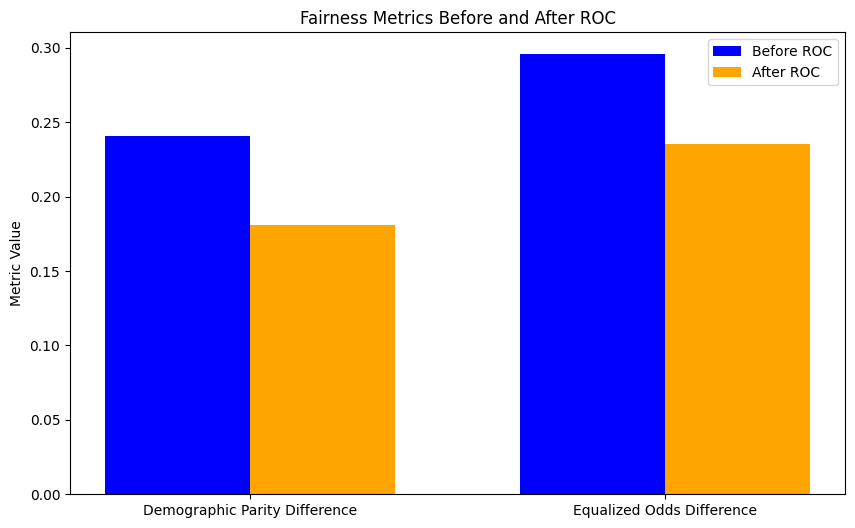

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
labels = ['Demographic Parity Difference', 'Equalized Odds Difference']
before_roc = [0.2408, 0.2956]
after_roc = [0.1808, 0.2356]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, before_roc, width, label='Before ROC', color='blue')
rects2 = ax.bar(x + width/2, after_roc, width, label='After ROC', color='orange')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Metric Value')
ax.set_title('Fairness Metrics Before and After ROC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()


In [31]:
pip install requests_mock pyqt5 pyqtwebengine


  Obtaining dependency information for requests_mock from https://files.pythonhosted.org/packages/97/ec/889fbc557727da0c34a33850950310240f2040f3b1955175fdb2b36a8910/requests_mock-1.12.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyqt5 from https://files.pythonhosted.org/packages/11/64/42ec1b0bd72d87f87bde6ceb6869f444d91a2d601f2e67cd05febc0346a1/PyQt5-5.15.11-cp38-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pyqtwebengine from https://files.pythonhosted.org/packages/2e/3d/8961b3bb00c0979280a1a160c745e1d543b4d5823f8a71dfa370898b5699/PyQtWebEngine-5.15.7-cp38-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for PyQt5-sip<13,>=12.15 from https://files.pythonhosted.org/packages/e9/7e/4b87c65adf9cb74895acc129043d04bb300436cab1e39469f4a9fc40b602/PyQt5_sip-12.15.0-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for PyQt5-Qt5<5.16.0,>=5.15.2 from https://files.pythonhosted.org/packag

In [ ]:
全局解释：

In [1]:
!pip install dash
!pip install dash-bootstrap-components
!pip install plotly


In [8]:
!pip install dash-bootstrap-components


In [27]:
pip install dtreeviz


  Obtaining dependency information for dtreeviz from https://files.pythonhosted.org/packages/b3/e8/44eb59345d8ba9d2f6610df6441d63082f46021c1685de24716c22f55383/dtreeviz-2.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for graphviz>=0.9 from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for colour from https://files.pythonhosted.org/packages/74/46/e81907704ab203206769dee1385dc77e1407576ff8f50a0681d0a6b541be/colour-0.1.5-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip uninstall numpy -y


Found existing installation: numpy 1.24.0
Uninstalling numpy-1.24.0:
  Successfully uninstalled numpy-1.24.0


In [18]:
!pip uninstall tables gensim fairlearn seaborn -y
!pip install numpy==1.24.3



Found existing installation: tables 3.8.0
Uninstalling tables-3.8.0:
  Successfully uninstalled tables-3.8.0
Found existing installation: gensim 4.3.0
Uninstalling gensim-4.3.0:
  Successfully uninstalled gensim-4.3.0
Found existing installation: fairlearn 0.10.0
Uninstalling fairlearn-0.10.0:
  Successfully uninstalled fairlearn-0.10.0
Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Successfully uninstalled seaborn-0.12.2
  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/ee/6c/7217a8844dfe22e349bccbecd35571fa72c5d7fe8b33d8c5540e8cc2535c/numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0


In [21]:
!pip install numpy==1.24.4


  Obtaining dependency information for numpy==1.24.4 from https://files.pythonhosted.org/packages/c0/bc/77635c657a3668cf652806210b8662e1aff84b818a55ba88257abf6637a8/numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [22]:
!pip install --upgrade numba fairlearn seaborn tables gensim


  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/9a/51/a4dc2c01ce7a850b8e56ff6d5381d047a5daea83d12bad08aa071d34b2ee/numba-0.60.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for llvmlite<0.44,>=0.43.0dev0 from https://files.pythonhosted.org/packages/ee/e1/38deed89ced4cf378c61e232265cfe933ccde56ae83c901aa68b477d14b1/llvmlite-0.43.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 25.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.40.0
    Uninstalling llvmlite-0.40.0:
      Successfully uninstalled llvmlite-0.40.0
  Attempting uninstall: numba
    Found existing installation: numba 0.57.0
    Uninstalling numba-0.57.0:
      Successfully uninstalled numba-0.57.0


In [ ]:
# 选择一个有代表性的数据点
instance_index = 25  # 这个可以根据需要选择
original_instance = X_test.iloc[instance_index]

# 生成该数据点的局部解释
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_index], original_instance)

# 修改敏感属性，比如将年龄从年轻改为老年
modified_instance = original_instance.copy()
modified_instance['age'] = 65  # 将年龄修改为65岁

# 重新计算局部解释
modified_shap_values = explainer.shap_values(modified_instance.values.reshape(1, -1))
shap.force_plot(explainer.expected_value[1], modified_shap_values[1], modified_instance)


In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 加载数据集
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=42)

# 训练决策树模型
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# 可视化决策树
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=data.feature_names, class_names=data.target_names, rounded=True)
plt.show()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/huashenglong/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/huashenglong/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/huashenglong/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
    self.io_loop.start()

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [3]:
from sklearn.tree import export_graphviz
import graphviz

# 导出为 Graphviz 格式
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=data.feature_names,  
                           class_names=data.target_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # 将结果保存为文件
graph.view()  # 在系统默认的查看器中打开图像


NameError: name 'clf' is not defined